In [64]:
%matplotlib inline
import warnings
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [65]:
df = pd.read_excel('data/sales.xlsx', index_col=0)

In [66]:
df.head()

,sales_A,sales_B
day,,
1,28252,15266
2,19669,8991
3,9639,8252
4,7102,13554
5,12865,4283


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 1 to 45
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   sales_A  45 non-null     int64
 1   sales_B  45 non-null     int64
dtypes: int64(2)
memory usage: 1.1 KB


In [68]:
df.index

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
           dtype='int64', name='day')

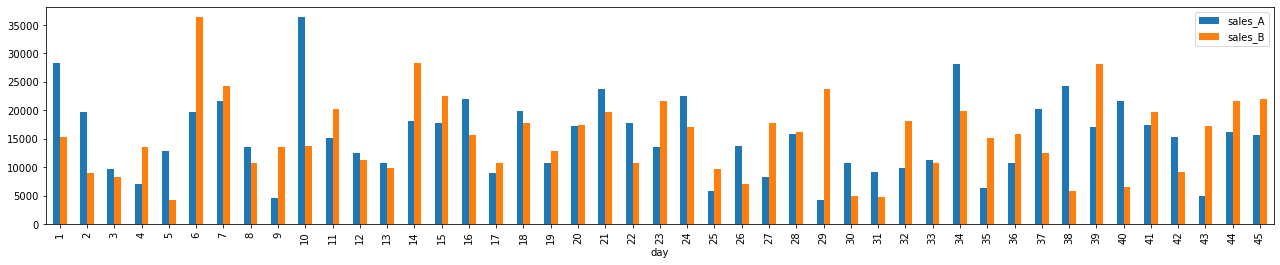

In [69]:
df.plot.bar(figsize = (22,4));

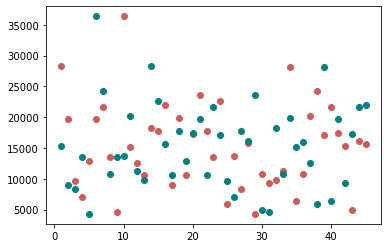

In [70]:
plt.scatter(x = df.index,y = df.sales_A, c = 'indianred');
plt.scatter(x = df.index,y = df.sales_B, c = 'teal');

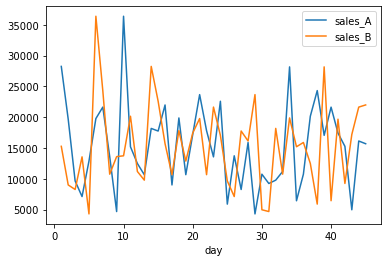

In [71]:
df.plot();

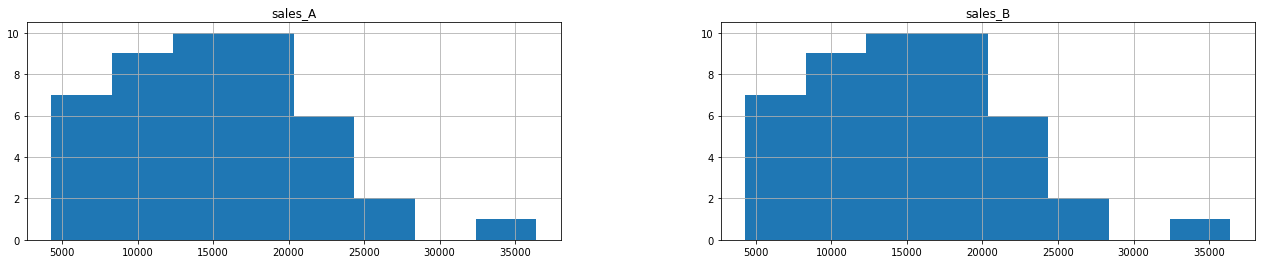

In [72]:
df.hist(bins=8,figsize = (22,4));

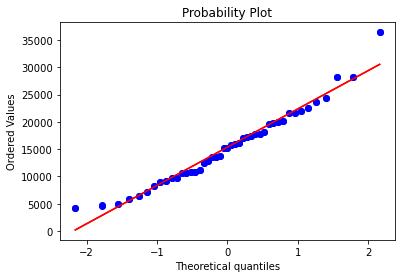

In [73]:
from scipy import stats
stats.probplot(df.sales_A, plot=plt);
stats.probplot(df.sales_B, plot=plt);

When points on the plot tend to lay on the diagonal line, it means that the data(the sample) are fitting the Gaussian model in a “good” way.

The first step is recognixing what sort of distribution to fit our data to. A couple of observations:

-The data are skewed, with a longer tail to the right than to the left

-The data are positive-valued, since they are measuring sales

-The data are continuous

# The method of moments

In [74]:
df_mean = df.mean(axis = 0)
print(df_mean)

sales_A    15357.155556
sales_B    15360.155556
dtype: float64


In [75]:
df_var = np.var(df)
df_var1 = df.var(axis = 0, ddof=0)
print(df_var,'\n', df_var1)

sales_A    4.698664e+07
sales_B    4.698731e+07
dtype: float64 
 sales_A    4.698664e+07
sales_B    4.698731e+07
dtype: float64


We then use these moments to estimate alfa  and beta for each design(A, B):

In [76]:
alpha = (df_mean ** 2 / df_var)
beta = df_var / df_mean
print(alpha,'\n', beta)

sales_A    5.019347
sales_B    5.021236
dtype: float64 
 sales_A    3059.592320
sales_B    3059.038705
dtype: float64


In [77]:
# another method
l_est = df_mean / df_var # lambda estimation (rate)
a_est = (df_mean ** 2) / l_est # alpha estimation
print('Lambda estimation: {}'.format(l_est))
print('Alpha estimation: {}'.format(a_est))

Lambda estimation: sales_A    0.000327
sales_B    0.000327
dtype: float64
Alpha estimation: sales_A    7.215811e+11
sales_B    7.217324e+11
dtype: float64


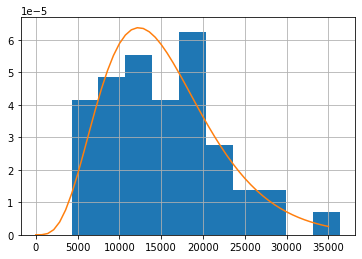

In [78]:
from scipy.stats.distributions import gamma

df.sales_A.hist(density=True);
plt.plot(np.linspace(0, 35000), gamma.pdf(np.linspace(0, 35000), a = alpha[0], loc = 0, scale = beta[0]));

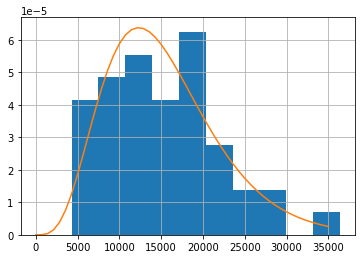

In [79]:
df.sales_B.hist(density=True);
plt.plot(np.linspace(0, 35000), gamma.pdf(np.linspace(0, 35000), a = alpha[1], loc = 0, scale = beta[1]));

# The maximum likelihood method

In [80]:
import statsmodels.api as sm
ols = sm.OLS(df.sales_A, df.index).fit()
print(ols.summary())

                                 OLS Regression Results                                
Dep. Variable:                sales_A   R-squared (uncentered):                   0.597
Model:                            OLS   Adj. R-squared (uncentered):              0.588
Method:                 Least Squares   F-statistic:                              65.09
Date:                Thu, 27 Jan 2022   Prob (F-statistic):                    3.22e-10
Time:                        17:24:01   Log-Likelihood:                         -481.28
No. Observations:                  45   AIC:                                      964.6
Df Residuals:                      44   BIC:                                      966.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

A very useful package is the fitter package, which by default estimates the distribution from which the sample is drawn. It is quite useful since it is not needed to know the likelihood function, but it is enough to only specify the sample and a list of distributions to test can be passed:

,sumsquare_error,aic,bic,kl_div
dweibull,1.551667e-07,2210.974279,-865.424295,inf
gamma,1.628441e-07,2163.056741,-863.251080,inf
uniform,1.950282e-07,2079.459287,-858.941961,inf


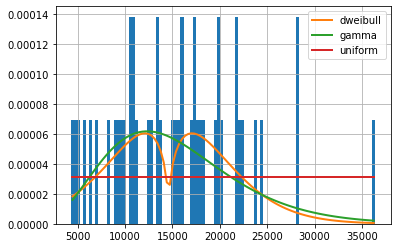

In [81]:
from fitter import Fitter
f = Fitter(df.sales_B, distributions=['gamma', 'dweibull', 'uniform'])
f.fit()
f.summary()

Statistical tests

It is possible to do a different statistical test to assess the goodness of fit, meaning how good the theoretical model fits the data. Those tests take into account the sample under a “global” point view, taking into account all the characteristics of the sample under study (mean, variance, the shape of the distribution…) and are distribution-agnostic, meaning they are independent of the distribution under study.
The first test under analysis, to assess the goodness of fit is the χ2 (chi-square). It is based on the comparison between the empirical frequencies (expected frequencies) and the observed frequencies, built on the desired density function. The χ2 can be used both for discrete and continuous variable and its mathematical formula is the following:

Where 𝑂𝑖 are the observed frequencies, 𝐸𝑖 the theoretical frequencies and 𝑘 the number of classes or intervals. This statistic is asymptotically distributed around a random variable denominated χ2 with 𝑘−𝑝−1 degree of freedom, where 𝑝 is the number of parameters estimated by the model.
The test is valid under the following conditions:

the sample should be big enough (since the distribution is asymptotic χ2)

The number of expected frequencies for each class cannot be less than 5.

It is needed to apply the Yates correction for continuity (continuity correction), which consists in subtracting 0.5 from the difference between each observed value and its expected value |𝑂𝑖−𝐸𝑖|.

15000.0 15000.0 0.01632993161855452 0.0004
45


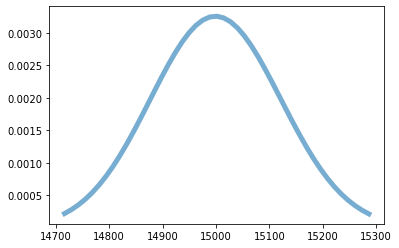

In [82]:
#a = 3.5 # shape parameter
a = 15000
mean, var, skew, kurt = gamma.stats(a, moments='mvsk')
print(mean, var, skew, kurt)
x = np.linspace(gamma.ppf(0.01, a),
               gamma.ppf(0.99, a), 45)
plt.plot(x, gamma.pdf(x, a), lw=5, alpha=0.6)

data = df.sales_A
hist, edges = np.histogram(data, bins)
print(hist.sum())
freq = hist/float(hist.sum())
#plt.bar(bins[:-1], freq, width = 2500 , ec="k", color='red')
plt.show()

#plt.hist(r, density=True, alpha=0.2)
#df.sales_A.hist(density=True, alpha = 0.3);

#gamma.pdf(np.linspace(0, 35000), a = alpha[1], loc = 0, scale = beta[1]));

Text(0.5, 1.0, 'Linear Scale')

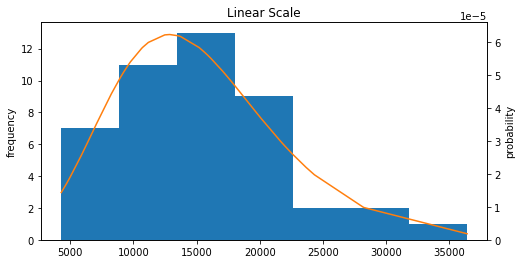

In [83]:
#Plotting probability density function with frequency counts
data = sorted(data)
# fit lognormal distribution
shape, loc, scale = stats.lognorm.fit(data, loc=0)
pdf_lognorm = stats.lognorm.pdf(data, shape, loc, scale)

fig, ax = plt.subplots(figsize=(8, 4))
ax2 = ax.twinx()

ax2.hist(data, bins='auto', density=True)
ax.hist(data, bins='auto')
ax2.plot(data, pdf_lognorm)
ax2.set_ylabel('probability')
ax.set_ylabel('frequency')
ax.set_title('Linear Scale')

In [84]:
# Compute the chi-sqaure test between the random sample r and the observed frequencies x
from scipy.stats import chisquare
r = df.sales_A
print(chisquare(r, x))

Power_divergenceResult(statistic=142599.82340928377, pvalue=0.0)


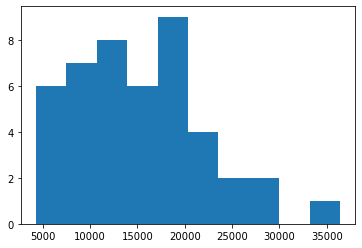

[6. 7. 8. 6. 9. 4. 2. 2. 0. 1.] 
 [ 4283.   7495.2 10707.4 13919.6 17131.8 20344.  23556.2 26768.4 29980.6
 33192.8 36405. ] <BarContainer object of 10 artists>


In [85]:
n, bins, patches = plt.hist(r, histtype='bar')
plt.show()
print(n, '\n', bins, patches)

In [86]:
from scipy.optimize import curve_fit

In [87]:
def logistic4(x, a, b, c, d):
    """The four paramter logistic function is often used to fit dose-response relationships."""
    return ((a-d)/(1.0+((x/c)**b))) + d

In [88]:
def fun(x, a, y):
    return (x/(a*a))*np.exp((-1*(x**2))/(2*a*a)) - y

In [89]:
estimated_rayleigh_scale = df_mean / np.sqrt(np.pi / 2)
print(estimated_rayleigh_scale)

sales_A    12253.237316
sales_B    12255.630969
dtype: float64


In [90]:
nobs = 45
xdata = np.linspace(0, 35000, nobs)
#ptrue = [10, 3, 1.5, 12]
ydata = df.sales_A
x0 = [1,1,0]

In [91]:
from scipy.optimize import least_squares
res_lsq = least_squares(fun, x0, args=(xdata, ydata))

ValueError: operands could not be broadcast together with shapes (3,) (45,) 

In [92]:
res_soft_l1 = least_squares(fun, x0, loss='soft_l1', f_scale=0.1,
                            args=(t_train, y_train))
res_log = least_squares(fun, x0, loss='cauchy', f_scale=0.1,
                        args=(t_train, y_train))

NameError: name 't_train' is not defined

In [93]:
perr = yerr=np.sqrt(np.diag(pcov))
print('Param\tTrue\tEstim (+/- 1 SD)')
for p, pt, po, pe  in zip('abcd', ptrue, popt, perr):
    print('%s\t%5.2f\t%5.2f (+/-%5.2f)' % (p, pt, po, pe))

NameError: name 'pcov' is not defined

In [94]:
x = np.linspace(0, 35000, 100)
y = f(x, *popt)
plt.plot(xdata, ydata, 'o')
plt.plot(x, y)
pass

NameError: name 'popt' is not defined

In [99]:
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names

#distn_names = _distn_names
distn_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto', 'dweibull']

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

In [100]:
def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

  1 / 6  : gamma
  2 / 6  : beta
  3 / 6  : rayleigh
  4 / 6  : norm
  5 / 6  : pareto
  6 / 6  : dweibull


Text(0, 0.5, 'Frequency')

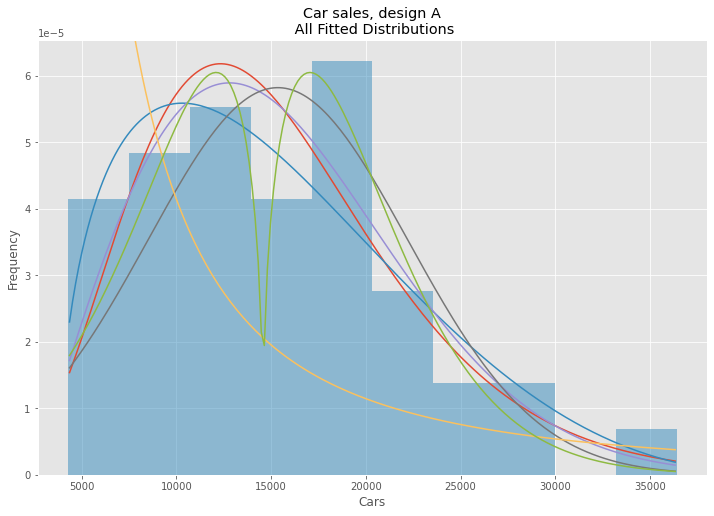

In [101]:
# Load data from statsmodels datasets
data = df.sales_A

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=10, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Car sales, design A\n All Fitted Distributions')
ax.set_xlabel(u'Cars')
ax.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

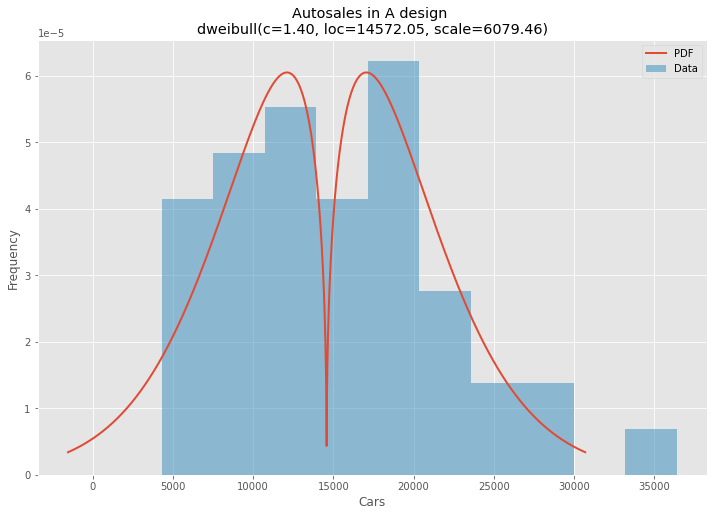

In [102]:
# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=10, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'Autosales in A design \n' + dist_str)
ax.set_xlabel(u'Cars')
ax.set_ylabel('Frequency')